In [24]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# 1. Pre-process the data

In [2]:
df = pd.read_csv('../data/telecom_churn.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
State                     3333 non-null object
Account length            3333 non-null int64
Area code                 3333 non-null int64
International plan        3333 non-null object
Voice mail plan           3333 non-null object
Number vmail messages     3333 non-null int64
Total day minutes         3333 non-null float64
Total day calls           3333 non-null int64
Total day charge          3333 non-null float64
Total eve minutes         3333 non-null float64
Total eve calls           3333 non-null int64
Total eve charge          3333 non-null float64
Total night minutes       3333 non-null float64
Total night calls         3333 non-null int64
Total night charge        3333 non-null float64
Total intl minutes        3333 non-null float64
Total intl calls          3333 non-null int64
Total intl charge         3333 non-null float64
Customer service calls    3333 non-null int64


In [5]:
df['International plan'] = df['International plan'].map({'Yes':1, 'No':0})
df['Voice mail plan'] = df['Voice mail plan'].map({'Yes':1, 'No':0})

In [6]:
df['Churn'] = df['Churn'].astype('int')

**Now all columns are numerical (other than 'States')**

In [7]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


# 2. Collect important columns

In [8]:
states = df.pop('State')

In [10]:
X, y = df.drop('Churn', axis=1), df['Churn']

# 3. Train a tree with our data

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [18]:
tree = DecisionTreeClassifier(random_state=17)

In [19]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [45]:
# 2 ways of getting accuracy for this estimator
print(tree.score(X_test, y_test)) # some estimators have '.score()' attribute
acc1 = accuracy_score(y_test, tree.predict(X_test))
print(acc1) # 'accuracy_score()' is the more general method

0.921
0.921


**Let's check how this compares to a constant-value estimator...**

In [26]:
y.value_counts(normalize=True)

0    0.855086
1    0.144914
Name: Churn, dtype: float64

**We'd get an accuracy of ~85% if we just predicted '0' every time**  
Let's see if we can do better...

# 4. Hyperparameter tuning

In [29]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [32]:
params = {'max_depth': np.arange(2,11), 'min_samples_leaf': np.arange(1,11)}

In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [34]:
better_tree = GridSearchCV(tree, params, n_jobs=-1, cv=skf, verbose=True)

In [35]:
better_tree.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    9.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [43]:
print(better_tree.best_params_)
print(better_tree.best_score_)

{'max_depth': 6, 'min_samples_leaf': 2}
0.9417059579939991


**Let's test the accuracy of the new, improved tree**

In [48]:
print(accuracy_score(y_test, better_tree.predict(X_test)))
acc2 = better_tree.score(X_test, y_test)
print(acc2)

0.947
0.947


### 4.1 Now let's do a CV by hand on the original tree to learn about it

In [52]:
from sklearn.model_selection import cross_val_score
from tqdm import tqdm_notebook # this helps visualize loop status

Let's see the CV scores for the original tree (with skf):

In [51]:
cv_scores = cross_val_score(tree, X_train, y=y_train, cv=skf)
cv_scores.mean()

0.9078429570539743

In [60]:
cv_accuracyByDepth, ho_accuracyByDepth = [], []
all_max_depth = np.arange(2,11)

# for each value of max_depth
for curr_max_depth in tqdm_notebook(all_max_depth):
    tree = DecisionTreeClassifier(random_state=17, max_depth= curr_max_depth)
    
    # perform cross-validation
    cv_scores = cross_val_score(tree, X_train, y=y_train, cv=skf)
    cv_accuracyByDepth.append(cv_scores.mean())
    
    # asses the model with the holdout data
    tree.fit(X_train, y_train)
    ho_accuracyByDepth.append(tree.score(X_test, y_test))
    

In [59]:
print('CV accuracies are: {} \nHO accuracies are: {}'.\
      format(cv_accuracyByDepth, ho_accuracyByDepth)) 

CV accuracies are: [0.8782678221870951, 0.9009888706105083, 0.9151317421951826, 0.93270165700159, 0.9382764610195661, 0.9339855345507347, 0.9339855345507347, 0.9318405308286846] 
HO accuracies are: [0.881, 0.905, 0.919, 0.94, 0.945, 0.946, 0.944, 0.945]


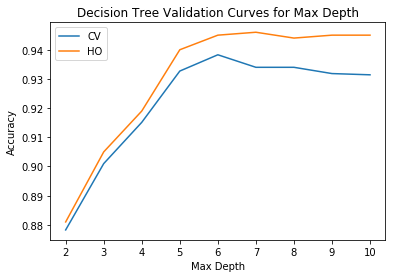

In [69]:
plt.plot(all_max_depth, cv_accuracyByDepth, label='CV');
plt.plot(all_max_depth, ho_accuracyByDepth, label='HO');
plt.legend(); plt.title('Decision Tree Validation Curves for Max Depth');
plt.xlabel('Max Depth'); plt.ylabel('Accuracy');

# 5. Visualizing the tree

In [73]:
from sklearn.tree import export_graphviz
from ipywidgets import Image
import pydotplus

In [75]:
x = export_graphviz(better_tree.best_estimator_, filled=True, feature_names=X.columns, out_file=None)
graph = pydotplus.graph_from_dot_data(x)
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x11S\x00\x00\x03\x91\x08\x06\x00\x00\x00\xe1\x02\x85…